# <center> Reinforcement Learning - Individual Assignment </center>

## <center> Text Flappy Bird </center>

## <center> Antoine DARGIER </center>

### <center> 31/03/2023 </center>

# 0. Installation and import of packages

In [ ]:
pip install git+https://gitlab-research.centralesupelec.fr/stergios.christodoulidis/text-flappy-bird-gym.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://gitlab-research.centralesupelec.fr/stergios.christodoulidis/text-flappy-bird-gym.git to /tmp/pip-req-build-_ros3klq
  Running command git clone --filter=blob:none --quiet https://gitlab-research.centralesupelec.fr/stergios.christodoulidis/text-flappy-bird-gym.git /tmp/pip-req-build-_ros3klq
  Resolved https://gitlab-research.centralesupelec.fr/stergios.christodoulidis/text-flappy-bird-gym.git to commit bdbddee93a6d59029989c32cc41748adb2724f51
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 KB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 66.4 MB/s eta 0:00:00
  Created wheel for text-flappy-bird-gym: filename=text_flappy_bird_gym-0.1.0-py3-none-any.whl size=7808 sha256=40111478a9814d6b056ec17aceb42622f05e7b8deb6cd758fbf65778fdc8eb33
  Stored in directory: /tmp/pip-ephem-wheel-cache-njnnkd

In [ ]:
import os, sys
import gymnasium as gym
import time
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import sem

from collections import defaultdict

import text_flappy_bird_gym

import warnings
warnings.filterwarnings("ignore")

# 1. First use with random agent

In [ ]:
if __name__ == '__main__':

    # initiate environment
    env = gym.make('TextFlappyBird-v0', height = 15, width = 20, pipe_gap = 4)
    obs = env.reset()

    # iterate
    while True:

        # Select next action
        action = env.action_space.sample()  # for an agent, action = agent.policy(observation)
        # Appy action and return new observation of the environment
        obs, reward, done, _, info = env.step(action)

        # Render the game
        os.system("clear")
        sys.stdout.write(env.render())
        time.sleep(0.2) # FPS

        # If player is dead break
        if done:
            break

    env.close()

Text Flappy Bird!
Score: 0
----------------------
[                  | ]
[                  | ]
[                  | ]
[                  | ]
[                  | ]
[                  | ]
[                  | ]
[      @           | ]
[                  | ]
[                  | ]
[                    ]
[                    ]
[                    ]
[                    ]
[                  | ]
^^^^^^^^^^^^^^^^^^^^^^
Player Action (Idle)
Distance From Pipe (dx=12,dy=-5)
Text Flappy Bird!
Score: 0
----------------------
[                 |  ]
[                 |  ]
[                 |  ]
[                 |  ]
[                 |  ]
[                 |  ]
[      @          |  ]
[                 |  ]
[                 |  ]
[                 |  ]
[                    ]
[                    ]
[                    ]
[                    ]
[                 |  ]
^^^^^^^^^^^^^^^^^^^^^^
Player Action (Flap)
Distance From Pipe (dx=11,dy=-6)
Text Flappy Bird!
Score: 0
----------------------
[     

# 2. Implementation of the two agents

In this section, we will implement two agents: Q-Learning and Expected Sarsa agents, because they are
popular RL algorithms that can be used to solve a variety of problems. The difference between the two agents is that Expected Sarsa takes into account the policy being followed by the agent when estimating the expected reward, whereas Q-learning
updates its Q-values based on the maximum expected reward of the next stateaction pair.

Here is the update function for Q-learing:

Q-learning update function.JPG

And here is the function for Expected Sarsa:

Sarsa update function.JPG

In [ ]:
class QLearningAgent():
    """
    First Agent: Q-Learning agent
    """

    def __init__(self, agent_init_info):
        self.epsilon = agent_init_info["epsilon"]
        self.step_size = agent_init_info["step_size"]
        self.discount = agent_init_info["discount"]

    def act(self, q, state):
        """
        epsilon-greedy policy
        """
        if np.random.random() < self.epsilon:
            current_action = env.action_space.sample()
        else:
            current_action = np.argmax(q[state])
        return current_action

    def update(self, q, state, action, next_state, next_action, reward):
        current_q = q[state][action]
        next_q = np.max(q[next_state])
        q[state][action] = current_q + self.step_size * (reward +  self.discount * next_q - current_q)

In [ ]:
class ExpectedSarsaAgent():
    """
    Second Agent: Expected Sarsa agent
    """

    def __init__(self, agent_init_info):
        self.epsilon = agent_init_info["epsilon"]
        self.step_size = agent_init_info["step_size"]
        self.discount = agent_init_info["discount"]

    def act(self, q, state):
        """
        epsilon-greedy policy
        """
        if np.random.random() < self.epsilon:
            current_action = env.action_space.sample()
        else:
            current_action = np.argmax(q[state])
        return current_action

    def update(self, q, state, action, next_state, next_action, reward):
        current_q = q[state][action]
        next_q = q[next_state][next_action]
        q[state][action] = current_q + self.step_size * (reward + self.discount * next_q - current_q)

# 3. Pipeline and training

Now that our agents are implemented, we can train them on the environment and print the sum of rewards per episode:

In [ ]:
agents = {"QLearning": QLearningAgent,
          "ExpectedSarsa": ExpectedSarsaAgent}
agent_init_info = {"epsilon" : 0.2, "step_size" : 0.7, "discount" : 0.8}
num_episodes = 20000

q_tables = {}
reward_sums = {}

for algorithm in ["QLearning", "ExpectedSarsa"]:
    current_agent = agents[algorithm](agent_init_info)

    q = defaultdict(lambda: np.zeros(2))
    reward_sums[algorithm] = []
    for i in range(num_episodes):
        state = env.reset()
        state = state[0]
        done = False
        total_reward = 0
        while not done:
            action = current_agent.act(q, state)
            next_state, reward, done, _, info = env.step(action)
            next_action = current_agent.act(q, next_state)
            if done == True:
                reward = -1
            total_reward += reward
            current_agent.update(q, state, action, next_state, next_action, reward)
            state = next_state
            if done:
                break
        reward_sums[algorithm].append(total_reward)
        env.close()
        q_tables[algorithm] = q

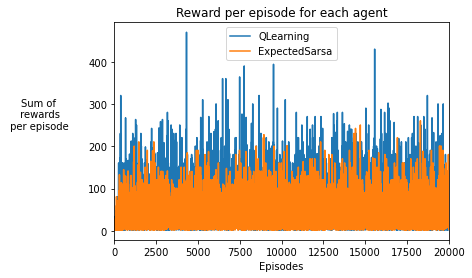

In [ ]:
for algorithm in ["QLearning", "ExpectedSarsa"]:
    plt.plot(reward_sums[algorithm], label=algorithm)
plt.xlabel("Episodes")
plt.ylabel("Sum of\n rewards\n per episode",rotation=0, labelpad=50)
plt.xlim(0, num_episodes)
plt.title("Reward per episode for each agent")
plt.legend()
plt.show()

In [ ]:
print("Average rewards:")
for algorithm in ["QLearning", "ExpectedSarsa"]:
    mean = np.mean(reward_sums[algorithm][5000:])
    print(f'{algorithm}: {mean}')

Average rewards:
QLearning: 46.66746666666667
ExpectedSarsa: 32.05493333333333


# 4. State Value plot

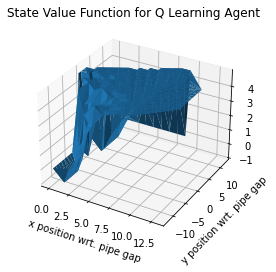

In [ ]:
q_policy = dict((k,np.max(v)) for k, v in q_tables['QLearning'].items())
x_list = []
y_list = []
z_list = []
for key in q_policy.keys():
    x_list.append(key[0])
    y_list.append(key[1])
for value in q_policy.values():
    z_list.append(value)
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_trisurf(x_list, y_list, z_list)
plt.title("State Value Function for Q Learning Agent")
plt.xlabel("x position wrt. pipe gap")
plt.ylabel("y position wrt. pipe gap")
#plt.zlabel("State Value function",rotation=0, labelpad=50)
plt.show()

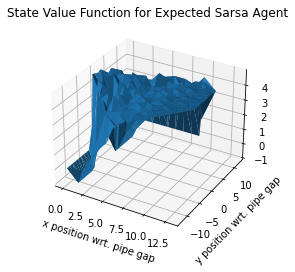

In [ ]:
q_policy = dict((k,np.max(v)) for k, v in q_tables['ExpectedSarsa'].items())
x_list = []
y_list = []
z_list = []
for key in q_policy.keys():
    x_list.append(key[0])
    y_list.append(key[1])
for value in q_policy.values():
    z_list.append(value)
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_trisurf(x_list, y_list, z_list)
plt.title("State Value Function for Expected Sarsa Agent")
plt.xlabel("x position wrt. pipe gap")
plt.ylabel("y position wrt. pipe gap")
plt.show()

# 5. Parameters Fine-Tuning

## 5.1 Step size fine tuning

In [ ]:
step_sizes = np.linspace(0.1,1.0,10)

agents = {"QLearning": QLearningAgent,
          "ExpectedSarsa": ExpectedSarsaAgent}
agent_init_info = {"epsilon" : 0.2, "step_size" : 0.7, "discount" : 0.8}
num_episodes = 10000

q_tables = {}
reward_sums = {}

for algorithm in ["QLearning", "ExpectedSarsa"]:
    for step_size in step_sizes:
        agent_init_info["step_size"] = step_size
        reward_sums[(algorithm, step_size)] = []

        q = defaultdict(lambda: np.zeros(2))
        current_agent = agents[algorithm](agent_init_info)
        for i in range(num_episodes):
            state = env.reset()
            state = state[0]
            done = False
            total_reward = 0
            while not done:
                action = current_agent.act(q, state)
                next_state, reward, done, _, info = env.step(action)
                next_action = current_agent.act(q, next_state)
                if done == True:
                    reward = -1
                total_reward += reward
                current_agent.update(q, state, action, next_state, next_action, reward)
                state = next_state
                if done:
                    break
            reward_sums[(algorithm, step_size)].append(total_reward)
            env.close()

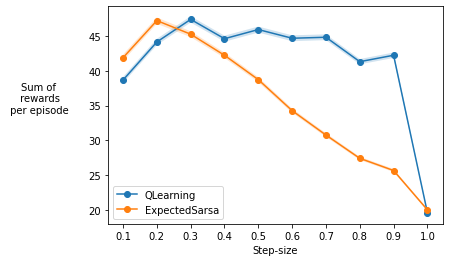

In [ ]:
for algorithm in ["QLearning", "ExpectedSarsa"]:
    algorithm_means = np.array([np.mean(reward_sums[(algorithm, step_size)]) for step_size in step_sizes])
    algorithm_stds = np.array([sem(reward_sums[(algorithm, step_size)]) for step_size in step_sizes])
    plt.plot(step_sizes, algorithm_means, marker='o', linestyle='solid', label=algorithm)
    plt.fill_between(step_sizes, algorithm_means + algorithm_stds, algorithm_means - algorithm_stds, alpha=0.2)
plt.legend()
plt.xlabel("Step-size")
plt.ylabel("Sum of\n rewards\n per episode",rotation=0, labelpad=50)
plt.xticks(step_sizes)
plt.show()

## 5.2 Discount fine tuning

In [ ]:
discounts = np.linspace(0.1,1.0,10)

agents = {"QLearning": QLearningAgent,
          "ExpectedSarsa": ExpectedSarsaAgent}
agent_init_info = {"epsilon" : 0.2, "step_size" : 0.7, "discount" : 0.8}
num_episodes = 10000

q_tables = {}
reward_sums = {}

for algorithm in ["QLearning", "ExpectedSarsa"]:
    for discount in discounts:
        agent_init_info["discount"] = discount
        reward_sums[(algorithm, discount)] = []

        q = defaultdict(lambda: np.zeros(2))
        current_agent = agents[algorithm](agent_init_info)
        for i in range(num_episodes):
            state = env.reset()
            state = state[0]
            done = False
            total_reward = 0
            while not done:
                action = current_agent.act(q, state)
                next_state, reward, done, _, info = env.step(action)
                next_action = current_agent.act(q, next_state)
                if done == True:
                    reward = -1
                total_reward += reward
                current_agent.update(q, state, action, next_state, next_action, reward)
                state = next_state
                if done:
                    break
            reward_sums[(algorithm, discount)].append(total_reward)
            env.close()

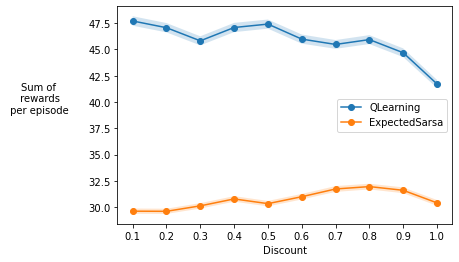

In [ ]:
for algorithm in ["QLearning", "ExpectedSarsa"]:
    algorithm_means = np.array([np.mean(reward_sums[(algorithm, discount)]) for discount in discounts])
    algorithm_stds = np.array([sem(reward_sums[(algorithm, discount)]) for discount in discounts])
    plt.plot(discounts, algorithm_means, marker='o', linestyle='solid', label=algorithm)
    plt.fill_between(discounts, algorithm_means + algorithm_stds, algorithm_means - algorithm_stds, alpha=0.2)
plt.legend()
plt.xlabel("Discount")
plt.ylabel("Sum of\n rewards\n per episode",rotation=0, labelpad=50)
plt.xticks(step_sizes)
plt.show()

# 6. Conclusion

In this project, we have seen that we are able two develop reinforcement learning agents that can play TFP. In our case, the Q-Learning agent seems to perform a little better than Expected Sarsa. In fact, its state value function seems more logical and it performs better results for different values of the step size and of the discount parameter. With a little work to develop a detector on the real game, our pipeline seems good to be used on the real game.